In [1]:
from prefect import task
import pandas as pd
import snowflake.connector

In [80]:
@task
def extract():
    #returns data set to pass through pipeline
    data = pd.read_csv('RDC_InventoryCoreMetrics_Zip.csv')
    
    return data

@task
def transform(data):
    '''Apply transformation to data'''
    load_data = data[['Month','ZipCode','ZipName','Median_Listing_Price','Active_Listing_Count_',
                     'Days_on_Market_', 'New_Listing_Count_','Price_Increase_Count_','Price_Decrease_Count_',
                     'Pending_Listing_Count_','Avg_Listing_Price',
                     'Total_Listing_Count','Pending_Ratio']]
    load_data["ZipName"] = load_data["ZipName"].str.replace(",","-")

    load_data.to_csv('to_snowflake.csv', index=False, line_terminator='\n', header=False)

@task
def load(data):
    '''LOAD TO SNOWFLAKE'''
    conn.cursor().execute(f'USE ROLE DATAMANAGER_LC')
    conn.cursor().execute('put file://./to_snowflake.csv @realtybates_housing_db.public.%realtor')
    conn.cursor().execute('use database realtybates_housing_db')
    conn.cursor().execute('COPY INTO realtybates_housing_db.public.realtor FROM @%realtor ON_ERROR=Continue')
    

In [3]:
from prefect import Flow
import os, sys, getpass

In [4]:
USER = 'lchewsnowflake'
ACCOUNT = 'jya18129'
WAREHOUSE = 'COMPUTE_WH'
DATABASE = 'REALTYBATES_HOUSING_DB.PUBLIC'
SCHEMA = ''
PASSWORD = getpass.getpass(prompt='Password:', stream=None)

Password: ····················


In [13]:
conn = snowflake.connector.connect(
    user=USER,
    password=PASSWORD,
    account=ACCOUNT,
    warehouse=WAREHOUSE,
    database=DATABASE,
    schema=SCHEMA)

In [14]:
# conn.cursor().execute('CREATE TABLE '
#                      '''realtor(Month string,ZipCode integer,ZipName string,Median_Listing_Price integer,Active_Listing_Count_ integer,
#                      Days_on_Market_ integer, New_Listing_Count_ integer,Price_Increase_Count_ integer,Price_Decrease_Count_ integer,
#                      Pending_Listing_Count_ integer,Avg_Listing_Price decimal,
#                      Total_Listing_Count integer,Pending_Ratio decimal)''')

In [81]:
with Flow('ETL') as flow:
    e = extract()
    t = transform(e)
    l = load(t)
    
flow.run()

[2019-11-04 23:19:23,409] INFO - prefect.FlowRunner | Beginning Flow run for 'ETL'
[2019-11-04 23:19:23,411] INFO - prefect.FlowRunner | Starting flow run.
[2019-11-04 23:19:23,419] INFO - prefect.TaskRunner | Task 'extract': Starting task run...
[2019-11-04 23:19:23,490] INFO - prefect.TaskRunner | Task 'extract': finished task run for task with final state: 'Success'
[2019-11-04 23:19:23,496] INFO - prefect.TaskRunner | Task 'transform': Starting task run...
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
[2019-11-04 23:19:23,652] INFO - prefect.TaskRunner | Task 'transform': finished task run for task with final state: 'Success'
[2019-11-04 23:

<Success: "All reference tasks succeeded.">

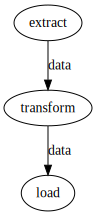

In [82]:
flow.visualize()